In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
from keras.optimizers import Adam
from datagen import SequenceDataGenerator
from embedding_model import SequenceEmbeddingModel, sequence_loss_with_params
from params import Params
from IPython.display import clear_output
from utils import *
from evaluate import sequence_eval

In [10]:
EPOCHS = 100
LEARNING_RATE = 1e-4
nan = float('nan')

In [3]:
params = Params()

params.EMBEDDING_DIM            = 6
params.BATCH_SIZE               = 1
params.NUM_CLASSES              = 4
params.NUM_SHAPE                = 3
params.NUM_FILTER               = [256, 256, 128]
params.ETH_MEAN_SHIFT_THRESHOLD = 1.5
params.DELTA_VAR                = 0.5
params.DELTA_D                  = 1.5
params.IMG_SIZE                 = 128
params.OUTPUT_SIZE              = 32
params.SEQUENCE_LEN             = 20
params.BACKBONE                 = 'xception'
params.TASK                     = 'sequence'
params.COLORS                   = np.random.random((params.NUM_SHAPE+1, 3))

In [4]:
model = SequenceEmbeddingModel(params)
optim = Adam(lr = LEARNING_RATE)
loss_function = sequence_loss_with_params(params)
model.compile(optim, loss = loss_function)
clear_output()

In [5]:
dg = SequenceDataGenerator(
    num_shape = params.NUM_SHAPE, 
    image_size = params.IMG_SIZE,
    sequence_len = params.SEQUENCE_LEN)
step = 0
loss_history = []

In [6]:
def fit_xy(model, x, y, loss_history, params, dg, step):
    history = model.fit(x, y, batch_size = 1, verbose = False)
    if math.isnan(history.history['loss'][-1]):
        return [x, y]
    loss_history.append(history.history['loss'][-1])
    if step % 100 == 99:
        clear_output()
        visualize_history(loss_history, 'loss')
    step += 1
    update_progress((step % 100) / 100)
    return loss_history, step

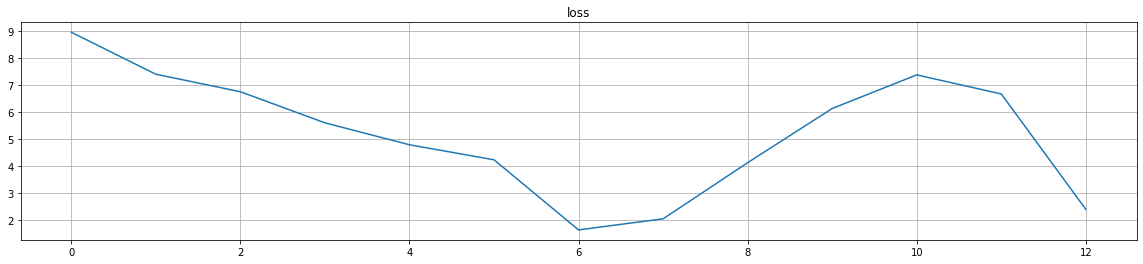

 Progress: [#####--------------------] 21.0% 

KeyboardInterrupt: 

In [7]:
class_num     = params.NUM_CLASSES
embedding_dim = params.EMBEDDING_DIM

for epoch in range(EPOCHS):
    for _ in range(100):
        sequence = dg.get_sequence()
        image_info = sequence[0]
        x, y = prep_half_pair_for_model(image_info, params)
        loss_history, step = fit_xy(model, x, y, loss_history, params, dg, step)
        for i in range(1, len(sequence)):
            prev_image_info = sequence[i-1]
            image_info = sequence[i]
            x, y = prep_half_pair_for_model(prev_image_info, params)
            outputs = np.squeeze(model.predict(x))
            emb = outputs[:, :, (class_num):(class_num + embedding_dim)]
            x, y = prep_pair_for_model(image_info, params, prev_image_info, emb)
            loss_history, step = fit_xy(model, x, y, loss_history, params, dg, step)
    sequence = dg.get_sequence()
    sequence_eval(model, sequence, params)
            
    model.save('sequence.h5')